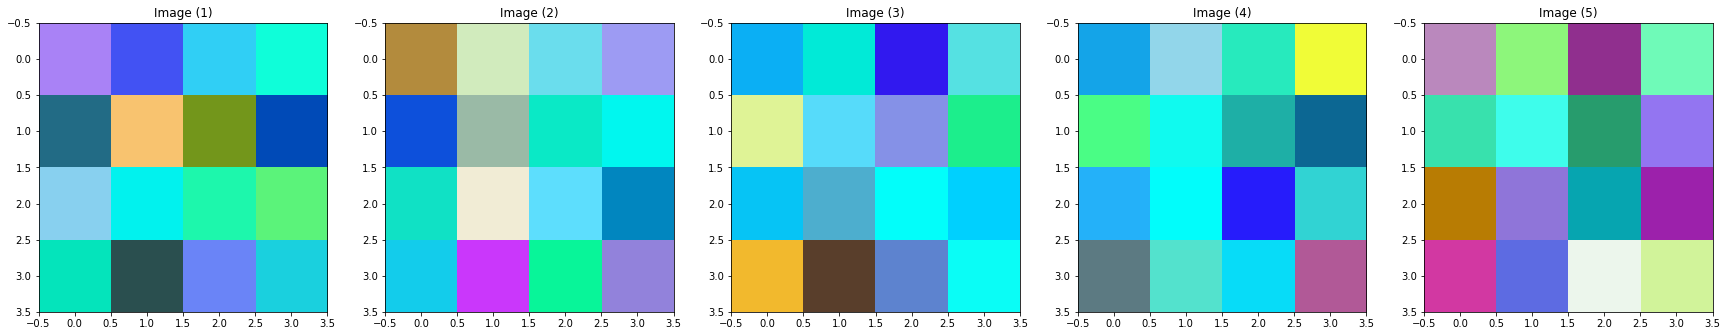

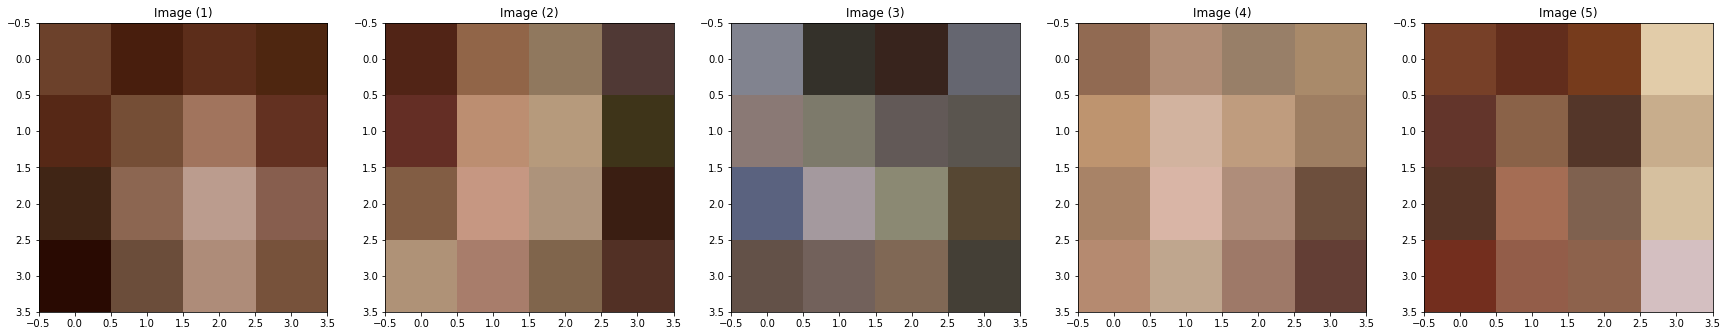

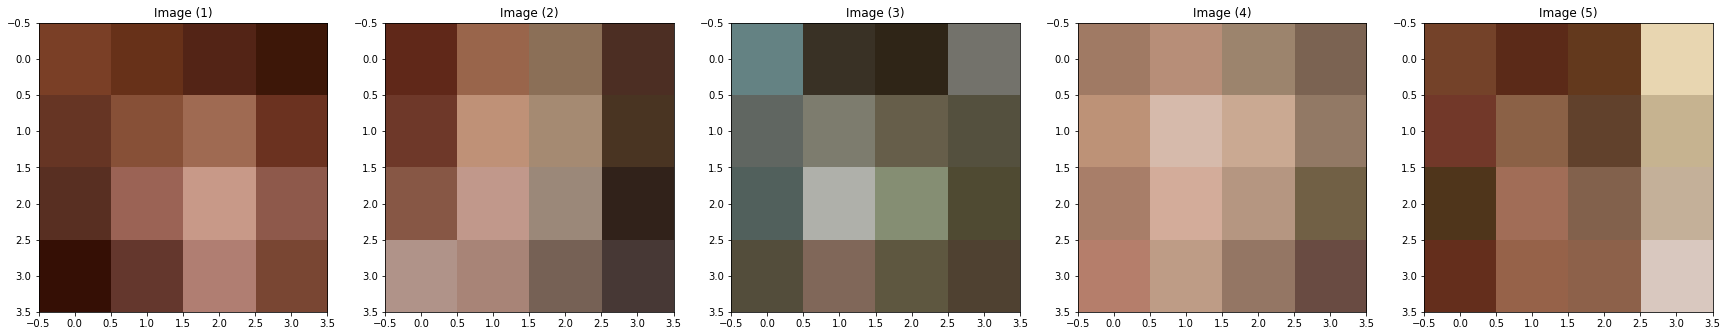

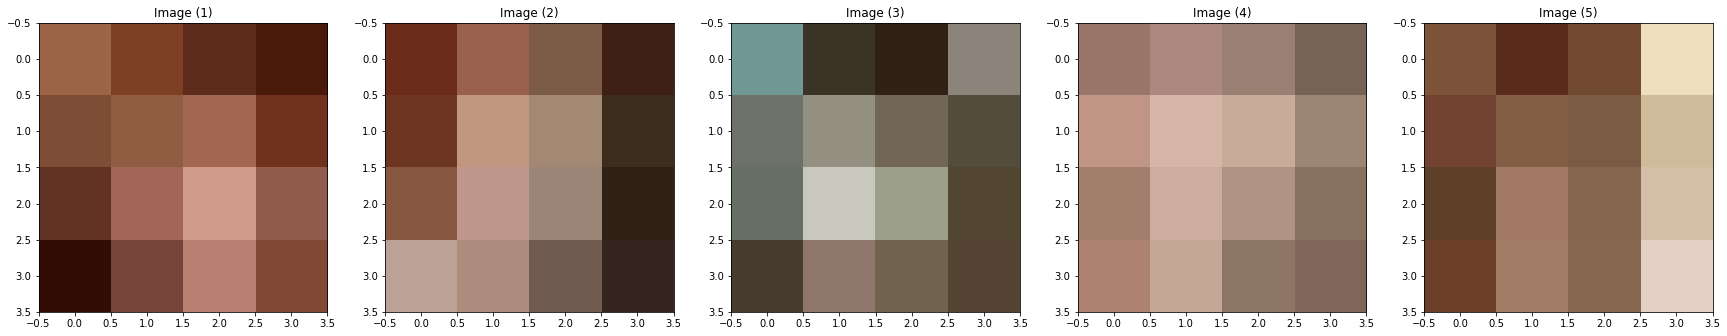

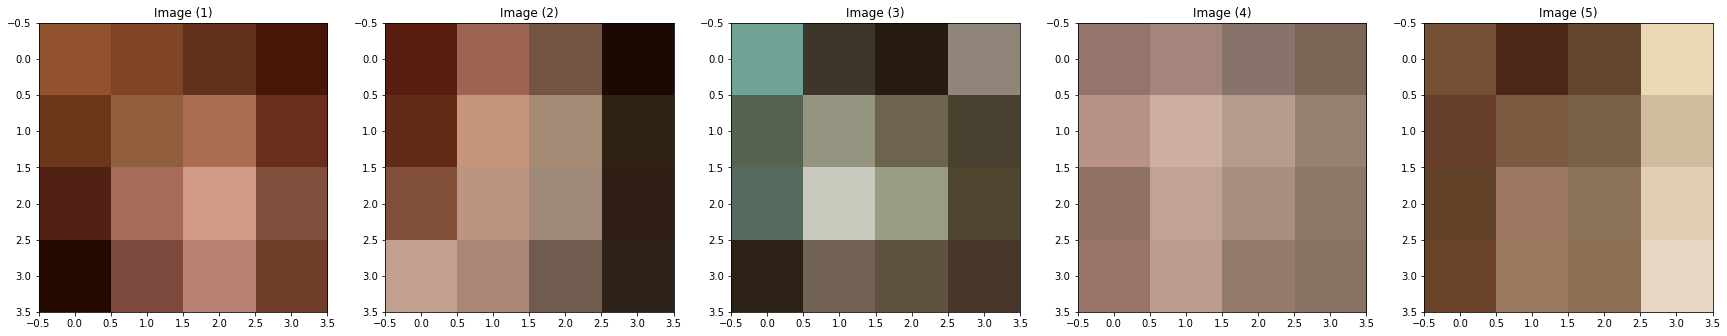

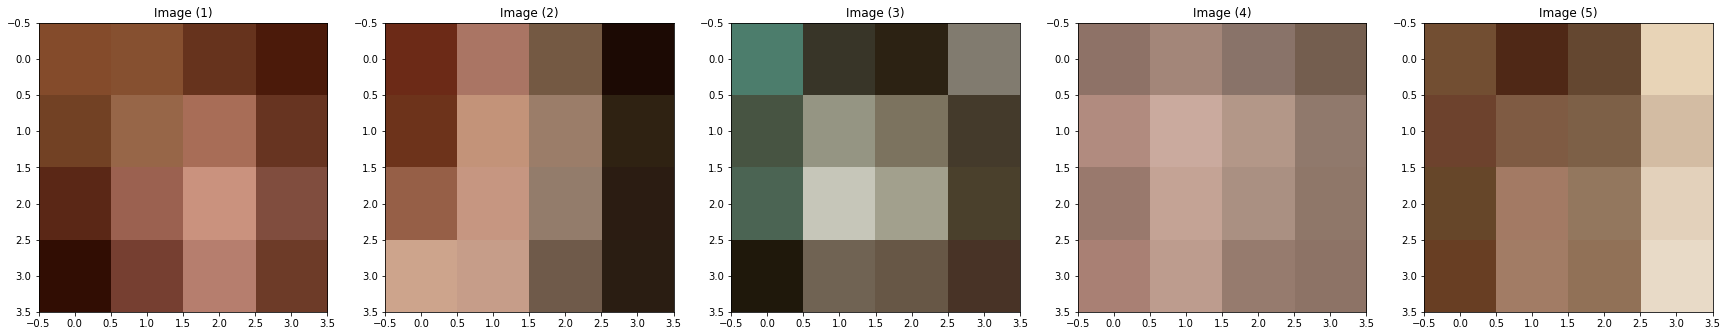

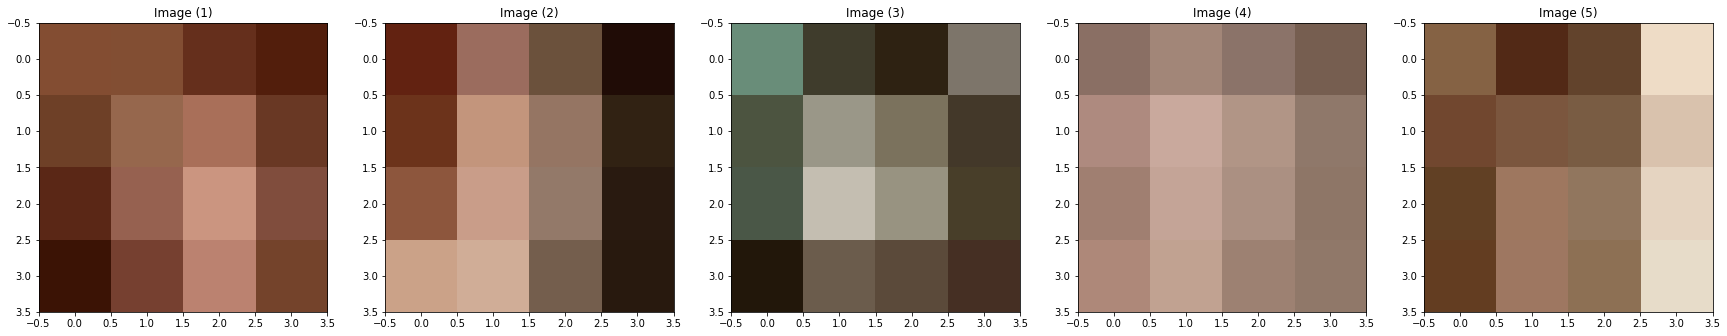

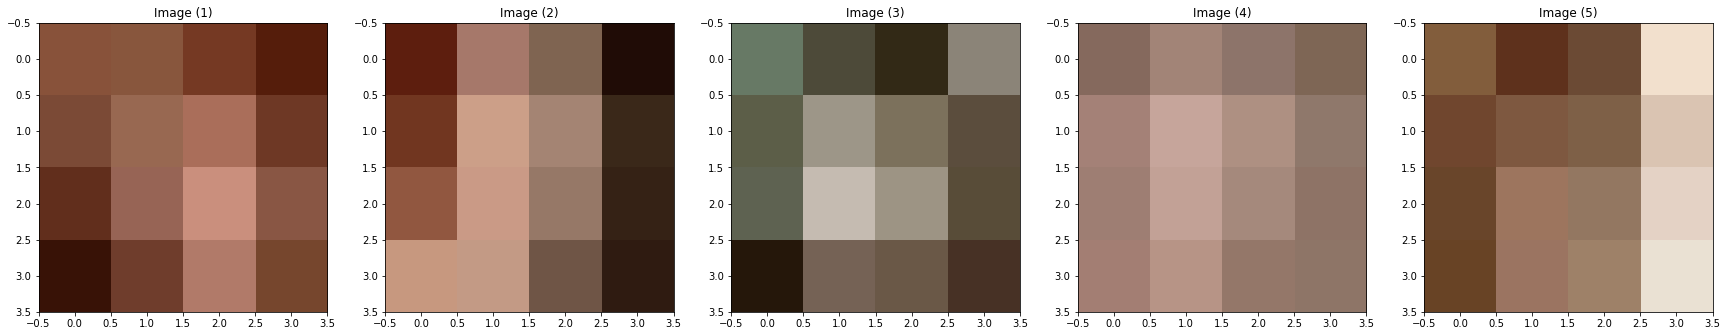

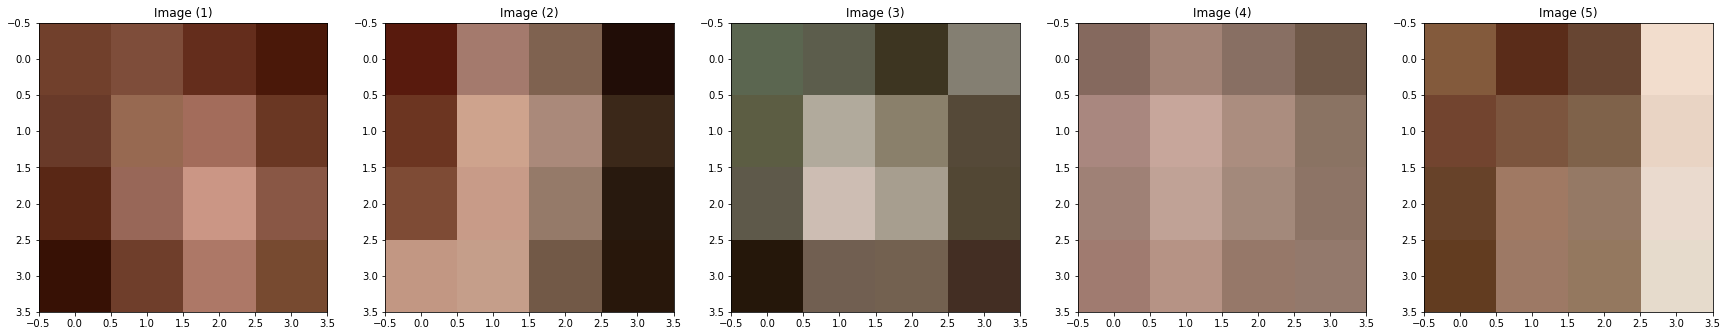

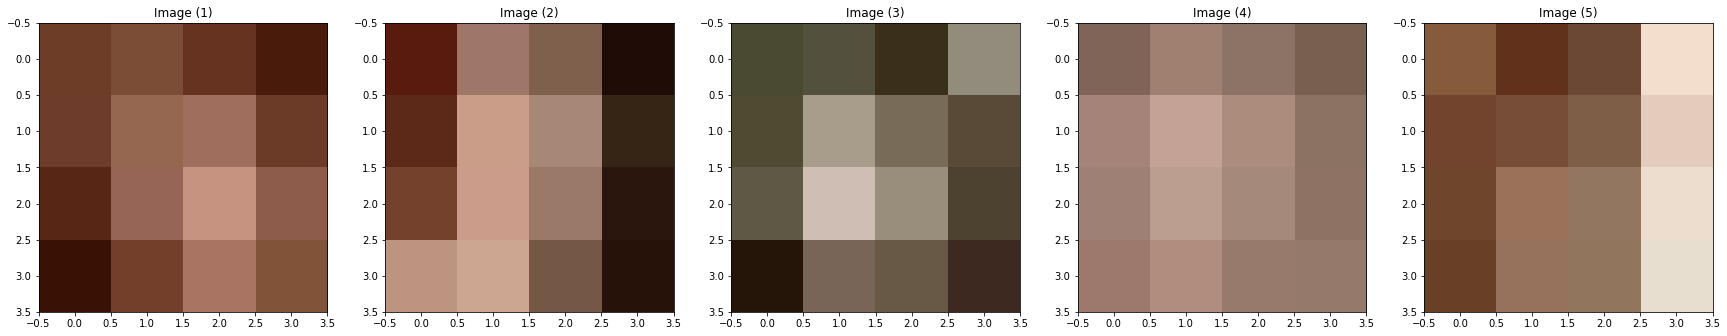

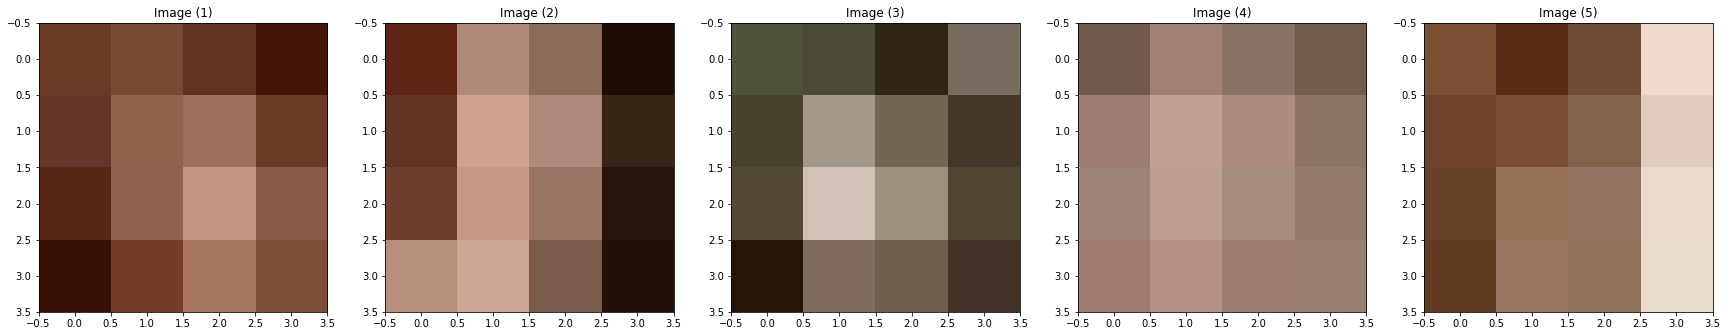

INFO:tensorflow:Assets written to: E:\Machine Learning & A.I\Saved Models\CelebA Generator 4\assets
INFO:tensorflow:Assets written to: E:\Machine Learning & A.I\Saved Models\CelebA Critic 4\assets


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, backend
import numpy as np
import PIL
from PIL import Image
import time
import os
import random

path = r"E:\Machine Learning & A.I\Celeb A HQ Dataset\celeba_hq\train\Both 4"
BATCH_SIZE = 64
seed = tf.random.normal([BATCH_SIZE,100])

glim = 10
conv_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim, axis=[0,1,2])
dense_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim)
b_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim)

clim = 10
cr_conv = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim, axis=[0,1,2])
cr_dense = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim)
cr_bias = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim)

        
#Applies the per-pixel normalization specified by the paper
class PixelNorm(layers.Layer):
    #custom layers don't need a constructor
    def call(self, tensor):
        return tensor/ tf.sqrt(tf.reduce_mean(tf.square(tensor),axis=1,keepdims=True)+10**(-8))
        
    
#Adds another step to the generator
def add_gen_block(gen, connect=(-6)):
    #replaces the final layer with a new upsampling layer
    start = gen.layers[connect].output
    x = layers.UpSampling2D(size=(2,2))(start)
    
    #the standard convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',kernel_constraint=conv_lim,
                     bias_constraint=b_lim)(x)
    x = PixelNorm()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',kernel_constraint=conv_lim,
                     bias_constraint=b_lim)(x)
    x = PixelNorm()(x)
    raw = layers.LeakyReLU()(x)
    rgb = layers.Conv2D(3, (1,1), padding='same',activation='tanh',kernel_initializer='he_normal',
                       kernel_constraint=conv_lim, bias_constraint=b_lim)(raw)
    
    prev_rgb = layers.Conv2D(3, (1,1), padding='same',activation='tanh',kernel_initializer='he_normal',
                            kernel_constraint=conv_lim, bias_constraint=b_lim)(start)
    prev_up = layers.UpSampling2D(size=(2,2))(prev_rgb)
    
    prev_a = layers.Multiply()([prev_up, (tf.ones_like(prev_up)-alpha)]) #PrevAlphaMod()(prev_up)
    this_a = layers.Multiply()([rgb, (tf.zeros_like(rgb)+alpha)]) #CurrentAlphaMod()(rgb)
    ws = layers.Add()([prev_a, this_a])
    
    model = keras.Model(inputs=gen.input, outputs=ws)
    return model
    
#Creates the base generator using the Functional API
def make_generator():
    #Input tensor of shape ([batchsize], 100)
    gen = keras.Input(shape=(100,))
    
    #Initial dense layers and resulting 4x4 image
    x = layers.Dense(1024,kernel_constraint=dense_lim,bias_constraint=b_lim)(gen)
    #LeakyReLU is a layer cannot be passed as an argument for activation keyword
    x = layers.LeakyReLU()(x) 
    x = layers.Reshape([4,4,64])(x)
    
    #First convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
                     kernel_constraint=conv_lim, bias_constraint=b_lim)(x)
    x = PixelNorm()(x)
    x = layers.LeakyReLU()(x)
    
    rgb = layers.Conv2D(3, (1,1), padding='same',activation='tanh',kernel_initializer='he_normal',
                        kernel_constraint=conv_lim, bias_constraint=b_lim,name='rgb')(x)

    model = keras.Model(inputs=gen, outputs=rgb)
    return model


def add_critic_block(disc, step):
    skip=[2,4,6,8,9,10] #removes the alpha weighting layers
    dim = step + 2
    new_disc = keras.Input(shape=(2**dim, 2**dim, 3))
    
    #PREVIOUS THROUGH PATH
    prev_down = layers.AveragePooling2D(pool_size=(2,2))(new_disc)
    prev_rgb = layers.Conv2D(64, (1,1),padding='same',kernel_initializer='he_normal',
                            kernel_constraint=cr_conv, bias_constraint=cr_bias)(prev_down)
    prev_out = layers.LeakyReLU()(prev_rgb)
    prev_alpha = layers.Multiply()([prev_out, (tf.ones_like(prev_out)-alpha)]) #PrevAlphaMod()(prev_out)
    
    #SELF THROUGH PATH
    #from rgb layer
    from_rgb = layers.Conv2D(64, (1,1),padding='same',kernel_initializer='he_normal',
                            kernel_constraint=cr_conv, bias_constraint=cr_bias)(new_disc) 
    
    #the standard convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
                     kernel_constraint=cr_conv, bias_constraint=cr_bias)(from_rgb)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
                     kernel_constraint=cr_conv, bias_constraint=cr_bias)(x)
    x = layers.LeakyReLU()(x)
    
    this_down = layers.AveragePooling2D(pool_size=(2,2))(x)
    this_alpha = layers.Multiply()([this_down, (tf.zeros_like(this_down)+alpha)]) #CurrentAlphaMod()(this_down)
    
    out = layers.Add()([prev_alpha, this_alpha])
    
    if step == 1:
        for layer in disc.layers[2:]:
                out = layer(out)
    else:
        for index, layer in enumerate(disc.layers[2:]):
            if index not in skip:
                out = layer(out)
            
    model = keras.Model(inputs=new_disc, outputs=out)
    return model
    
#The base critic
def make_critic(): 
    disc = keras.Input(shape=(4,4,3))
    
    #from rgb layer
    from_rgb = layers.Conv2D(64, (1,1),padding='same',kernel_initializer='he_normal',
                            kernel_constraint=cr_conv, bias_constraint=cr_bias)(disc)
    
    #batchnorm not used in wgan-gp
    #x = layers.BatchNormalization()(from_rgb)
    
    #the standard convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
                     kernel_constraint=cr_conv, bias_constraint=cr_bias)(from_rgb)
    x = layers.LeakyReLU()(x)
    
    #ending layers
    x = layers.Flatten()(x)
    x = layers.Dense(100,kernel_constraint=cr_dense, bias_constraint=cr_bias)(x)
    x = layers.LeakyReLU()(x)
    out = layers.Dense(1)(x)
    
    model = keras.Model(inputs=disc, outputs=out)
    return model


@tf.function
def train_critic(images):
    noise = tf.random.normal([BATCH_SIZE,100])
    #adds random noise to the input images 
    images += 0.05 * tf.random.uniform(images.shape)

    with tf.GradientTape() as crit_tape:
        fake_images = generator(noise, training=False)
        fake_out = tf.reduce_mean(critic(fake_images))
        real_out = tf.reduce_mean(critic(images))
        grad_pen = gradient_penalty(images, fake_images)**2
        crit_loss = fake_out - real_out + (10*grad_pen)
        
    crit_grads = crit_tape.gradient(crit_loss, critic.trainable_variables)    
    critic_optimizer.apply_gradients(zip(crit_grads, critic.trainable_variables))
    return crit_loss

#using code from a guide on keras site: 'wgan-gp overriding model_train.step'
@tf.function
def gradient_penalty(images, fake_img):
    #set up epsilon
    epsi = tf.random.uniform(shape=[BATCH_SIZE,1,1,1], maxval=1)
    #epsi = tf.repeat(epsi, HEIGHT, axis=1)
    #epsi = tf.repeat(epsi, WIDTH, axis=2)
    #epsi = tf.repeat(epsi, CHANNELS, axis=3)
    
    diff = fake_img - images
    interpolated = images + epsi * diff
    
    with tf.GradientTape() as x_hat_tape:
        x_hat_tape.watch(interpolated)
        x_hat_out = critic(interpolated)
    #x_hat_grads = x_hat_tape.gradient(x_hat_out, critic.trainable_variables)[0]  
    #this is incrorrect simply derive with the target as interpolated
    #the modified images being the interpolated
    x_hat_grads = x_hat_tape.gradient(x_hat_out, [interpolated])[0]
    
    #old code here is incorrect
    #x_hat_grads = tf.transpose(tf.reshape(x_hat_grads, [3,64]))
    #norm_out = tf.reduce_max(x_hat_grads, axis=1)
    
    #flatten grads and apply the norm
    norm = tf.sqrt(tf.reduce_sum(tf.square(x_hat_grads), axis=[1,2,3]))
    return tf.reduce_mean((norm-1)**2)


@tf.function
def train_generator():
    noise = tf.random.normal([(BATCH_SIZE*2), 100])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise)
        fake_out = critic(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_out)
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    return gen_loss
    
#Taken from github
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * (n_images-0))
    plt.show()

def image_generator(pictures): 
    for jpg in pictures:
        im = Image.open(path + "\\" + jpg) #Opens the image
        im_arr = np.asarray(im, dtype='float32')
        im_arr = (im_arr-127.5)/127.5
        yield im_arr
        
def generate_images(model):
    generated_images = []
    new_img = model(seed, training=False)
    for i in range(5):
        x = new_img[i].numpy()
        x = (x*127.5)+127.5
        final = x.astype('uint8')
        generated_images.append(final)
    return generated_images

def train():
    epochs = 10000
    n_critic=5
    pictures = os.listdir(path)
    loops = int(17943/BATCH_SIZE)
    imgs = generate_images(generator)
    show_images(imgs)
    step = 1/(epochs*0.5)
    ws_alpha = 0
    
    for i in range(epochs):
        for _ in range(n_critic):
            images = []
            for _ in range(BATCH_SIZE):
                jpg = random.choice(pictures)
                im = Image.open(path + "\\" + jpg) #Opens the image
                im_arr = np.asarray(im, dtype='float32')
                im_arr = (im_arr-127.5)/127.5
                images.append(im_arr)
            img_tensor = tf.convert_to_tensor(np.asarray(images))
            _ = train_critic(img_tensor)
            #_ = gradient_penalty(img_tensor, generator(tf.random.normal([BATCH_SIZE,100])))
            
        _ = train_generator()
        if (i+1)%1000 == 0 or (1+i) == epochs:
            imgs = generate_images(generator)
            show_images(imgs)

    generator.save("E:\Machine Learning & A.I\Saved Models\CelebA Generator 4")
    critic.save("E:\Machine Learning & A.I\Saved Models\CelebA Critic 4")
            
generator = make_generator()
critic = make_critic()

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
critic_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

train()


